# Introduction

<img src=images/pipeline1.jpg width="50%">

last update 2020/02/08

# Load libraries

In [1]:
import pandas as pd
import keras
import os
import numpy as np
from sklearn.metrics import log_loss
from keras import Model,Sequential
from keras.layers import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import glob
from mtcnn import MTCNN

Using TensorFlow backend.


# 1. Make Train Data

In [2]:
image_paths = glob.glob('opencv_method/dataset/made_hand/*_rgb.jpg')
images_length = len(image_paths)
print("there are",images_length,"images.")

there are 40519 images.


* As I am working for a project production, I do not need a test set. So I divide all the data into TrainSet and ValidationSet.
* And all the images are already in random order

In [3]:
import random

def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

In [4]:
train_ratio = 0.9
validataion_ration = 0.1

num_train = int(images_length*train_ratio)
num_valid = int(images_length*validataion_ration)

train_images = image_paths[0:num_train]
valid_images = image_paths[num_train:num_valid+num_train]
print("there are", len(train_images), "train images, and", len(valid_images), "validation images.")

there are 36467 train images, and 4051 validation images.


In [5]:
input_image_size = 256
label_ratio_x = input_image_size/480
label_ratio_y = input_image_size/640

def read_img(path):
    image = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, (input_image_size,input_image_size), interpolation = cv2.INTER_AREA) 
    return resized

def read_label(path):
    label_path = path[:-7]+"mask.npy"
    label = np.load(label_path)
    label_class = np.ones(6)
    for i in range(6):
        if(label[2*i] < 0):
            label_class[i] = 0
        else:
            label[2*i] = label_ratio_x * label[2*i]
            label[2*i+1] = label_ratio_y * label[2*i+1]
    return [label_class, label]

In [6]:
X = []
y1 = []
y2 = []
for img in tqdm(train_images):
    X.append(read_img(img))
    y1.append(read_label(img)[0])
    y2.append(read_label(img)[1])
    
val_X = []
val_y1 = []
val_y2 = []
for img in tqdm(valid_images):
    val_X.append(read_img(img))
    val_y1.append(read_label(img)[0])
    val_y2.append(read_label(img)[1])

In [19]:
def make_int(labels):
    label_out = labels
    for i in range(12):
        label_out[i] = int(labels[i])
    return label_out

def draw_label_show(labels, image, color = True): 
    labels = make_int(labels)
    for i in range(6):
        idx_x = 2*i + 1
        idx_y = 2*i
        if(labels[idx_x] > 0):
            if(color):
                cv2.circle(image,tuple([labels[idx_x], labels[idx_y]]),10,[255,0,255],-1)
            else:
                cv2.circle(image,tuple([labels[idx_x], labels[idx_y]]),4,[0,255,255],-1)
    
    for i in range(5):
        idx_x = 2*i + 1
        idx_y = 2*i
        start = tuple([labels[11], labels[10]])
        end = tuple([labels[idx_x], labels[idx_y]])
        if(labels[idx_x] > 0):
            if(color):
                cv2.line(image,start,end,[0,255,0],2)
            else:
                cv2.line(image,start,end,[255,0,0],1)
    return image

def draw_label_show_flag(labels, image, flags,color = True): 
    labels = make_int(labels)
    for i in range(6):
        idx_x = 2*i + 1
        idx_y = 2*i
        if(flags[i] > 0.5):
            if(color):
                cv2.circle(image,tuple([labels[idx_x], labels[idx_y]]),10,[255,0,255],-1)
            else:
                cv2.circle(image,tuple([labels[idx_x], labels[idx_y]]),4,[0,255,255],-1)
    
    for i in range(5):
        idx_x = 2*i + 1
        idx_y = 2*i
        start = tuple([labels[11], labels[10]])
        end = tuple([labels[idx_x], labels[idx_y]])
        if(flags[i] > 0.5):
            if(color):
                cv2.line(image,start,end,[0,255,0],2)
            else:
                cv2.line(image,start,end,[255,0,0],1)
    return image

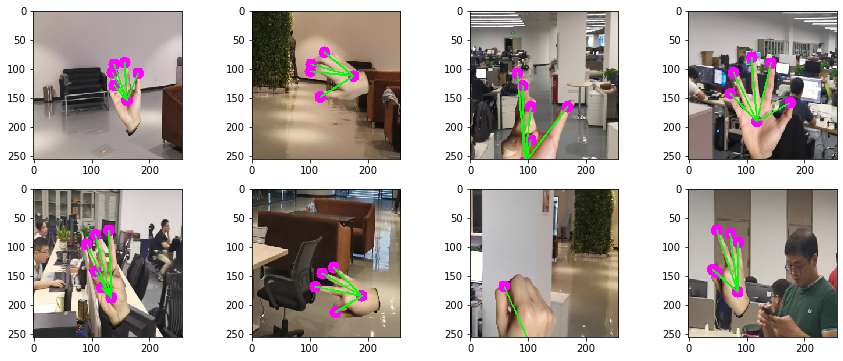

In [8]:
num_plot = [2,4]

count = 1
plt.figure(figsize=(15,6))
for i in range(num_plot[0]):
    for j in range(num_plot[1]):
        plt.subplot(num_plot[0],num_plot[1], count)
        count += 1
        idx = int(random.random() * len(X))
        
        image = X[idx]
        label_test = y2[idx]

        image_labeled = draw_label_show(label_test, image)
        plt.imshow(image_labeled)

# 2. Build the model

from (https://www.kaggle.com/unkownhihi/starter-kernel-with-cnn-model-ll-lb-0-69235)

In [101]:
def Hand_Loss(y_true, y_pred):
    object_mask = y_true[0]
    true_xy = y_true[1]
    
    predict_mask = y_pred[0]
    predict_xy = y_pred[1]
    
    xy_loss_scale = [1.0,1.0,1.0,1.0,1.0,0.1]
    label_scale = 10.0
    
    loss = 0

    class_loss = K.sum(label_scale * K.binary_crossentropy(object_mask, predict_mask+1e-5, from_logits=True))
    loss += K.abs(class_loss)
    
    for i in range(6):
        raw_true_xy = true_xy[i*2:i*2+2]
        raw_pred_xy = predict_xy[i*2:i*2+2]
        xy_loss = K.sum(object_mask[i] * xy_loss_scale[i] * (K.square((raw_true_xy - raw_pred_xy))))
        loss += xy_loss
    
    return loss

In [110]:
def InceptionLayer(a, b, c, d):
    def func(x):
        x1 = Conv2D(a, (1, 1), padding='same', activation='elu')(x)
        
        x2 = Conv2D(b, (1, 1), padding='same', activation='elu')(x)
        x2 = Conv2D(b, (3, 3), padding='same', activation='elu')(x2)
            
        x3 = Conv2D(c, (1, 1), padding='same', activation='elu')(x)
        x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='elu')(x3)
        
        x4 = Conv2D(d, (1, 1), padding='same', activation='elu')(x)
        x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='elu')(x4)
        y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
        return y
    return func
    
def define_model_mine(shape=(256,256,3)):
    x = Input(shape = shape)
    
    x1 = InceptionLayer(1, 4, 4, 2)(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x2 = InceptionLayer(2, 4, 4, 2)(x1)
    x2 = BatchNormalization()(x2)        
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
    x3 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
    x4 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x3)
    x4 = BatchNormalization()(x4)
    if shape==(256,256,3):
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
    else:
        x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    
    y1 = Flatten()(x4)
    y1 = Dropout(0.5)(y1)
    y1 = Dense(16)(y1)
    y1 = LeakyReLU(alpha=0.1)(y1)
    #y1 = Dropout(0.5)(y1)
    y1 = Dense(6, activation = 'sigmoid')(y1)
    
    y2 = Flatten()(x4)
    y2 = Dropout(0.5)(y2)
    y2 = Dense(128)(y2)
    y2 = LeakyReLU(alpha=0.1)(y2)
    y2 = Dense(12)(y2)
    y2 = LeakyReLU(alpha=0.1)(y2)
    
    model = Model(inputs = x, outputs = [y1,y2])
    
    #model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4))
    model.compile(loss=Hand_Loss,optimizer=Adam(lr=1e-4))
    
    #model.summary()
    return model

In [111]:
def define_model(shape=(256,256,3)):
    x = Input(shape = shape)
    
    x1 = InceptionLayer(1, 4, 4, 2)(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x2 = InceptionLayer(2, 4, 4, 2)(x1)
    x2 = BatchNormalization()(x2)        
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
    x3 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
    x4 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x3)
    x4 = BatchNormalization()(x4)
    if shape==(256,256,3):
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
    else:
        x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
        
    y = Flatten()(x4)
    y = Dropout(0.5)(y)
    y = Dense(16)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(1, activation = 'sigmoid')(y)
    model=Model(inputs = x, outputs = y)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4))
    #model.summary()
    return model

In [112]:
df_model=define_model()
df_model.load_weights('MESO/MesoInception_DF')
f2f_model=define_model()
f2f_model.load_weights('MESO/MesoInception_F2F')

# 3. Train the model

In [113]:
from keras.callbacks import LearningRateScheduler
import gc

In [114]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

## 3.1 Train with pretrained model

In [115]:
model = define_model_mine((256,256,3))
#model.load_weights('../input/meso-pretrain/MesoInception_DF')
for new_layer, layer in zip(model.layers[1:20], df_model.layers[1:20]):
    new_layer.set_weights(layer.get_weights())
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 256, 256, 4)  16          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 256, 256, 4)  16          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 256, 256, 2)  8           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_67 

In [116]:
lrs = [1e-3,1e-3,5e-4,5e-4,2e-4,   1e-4,1e-4,1e-4,1e-4,5e-4,   1e-4,1e-4,1e-4,1e-4,5e-4, 1e-4,1e-4,1e-4,1e-4,1e-4]
def schedule(epoch):
    return lrs[epoch]

In [117]:
history = LossHistory()
model.fit([X],[y1,y2],validation_split=0.1,epochs=len(lrs),callbacks=[LearningRateScheduler(schedule),history])

Train on 32820 samples, validate on 3647 samples
Epoch 1/20
32820/32820 [==============================] - 87s 3ms/step - loss: 4715674.4691 - dense_14_loss: 23.3719 - leaky_re_lu_11_loss: 4715651.0399 - val_loss: 10909265.8009 - val_dense_14_loss: 21.8867 - val_leaky_re_lu_11_loss: 10909243.8549
Epoch 2/20
32820/32820 [==============================] - 85s 3ms/step - loss: 4236195.9819 - dense_14_loss: 23.3397 - leaky_re_lu_11_loss: 4236172.5918 - val_loss: 3517883.8974 - val_dense_14_loss: 21.5946 - val_leaky_re_lu_11_loss: 3517862.3024
Epoch 3/20
32820/32820 [==============================] - 84s 3ms/step - loss: 3982832.2806 - dense_14_loss: 23.4513 - leaky_re_lu_11_loss: 3982808.7843 - val_loss: 4017233.9956 - val_dense_14_loss: 21.5946 - val_leaky_re_lu_11_loss: 4017212.3414
Epoch 4/20
32820/32820 [==============================] - 85s 3ms/step - loss: 3752677.4182 - dense_14_loss: 23.3657 - leaky_re_lu_11_loss: 3752654.0247 - val_loss: 3721395.9934 - val_dense_14_loss: 21.5944 -

4051/4051 [==============================] - 4s 1ms/step
Test score: 2796923.5477659837
Test accuracy: 27.767571528615317


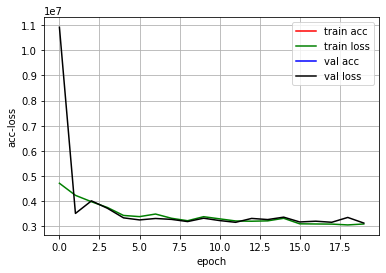

In [118]:
score = model.evaluate([val_X], [val_y1, val_y2], verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

history.loss_plot('epoch')

In [119]:
pred = model.predict([val_X])

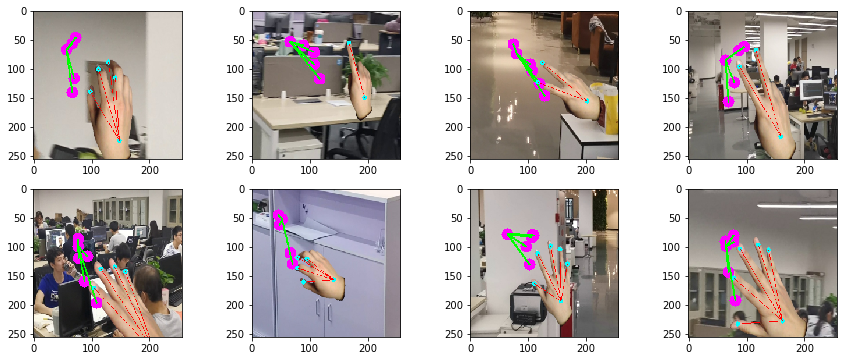

In [120]:
num_plot = [2,4]

count = 1
plt.figure(figsize=(15,6))
for i in range(num_plot[0]):
    for j in range(num_plot[1]):
        plt.subplot(num_plot[0],num_plot[1], count)
        count += 1
        idx = int(random.random() * len(val_X))
        
        image = val_X[idx].copy()
        label_test = pred[1][idx]
        flag_test = pred[0][idx]

        #image_labeled = draw_label_show(label_test, image)
        image_labeled = draw_label_show_flag(label_test, image, flag_test)
        label_test_true = val_y2[idx]
        image_labeled = draw_label_show(label_test_true, image, False)
        
        plt.imshow(image_labeled)

In [ ]:
K.clear_session()
del model
gc.collect()

The pretrained model is used for classification, if we want to use its encoded feature, we need more layers additional. 
The simple network as above will not work.

## 3.2  Train Test Mine

In [122]:
lrs = [1e-3,1e-3,5e-4,5e-4,2e-4,   1e-4,1e-4,1e-4,1e-4,5e-4,   1e-4,1e-4,1e-4,1e-4,5e-4, 1e-4,1e-4,1e-4,1e-4,1e-4 ,
       1e-4,8e-5,7e-5,6e-5,5e-5,   1e-4,8e-5,7e-5,6e-5,5e-5,   5e-5,5e-5,5e-5,4e-5,4e-5, 3e-5,3e-5,3e-5,3e-5,3e-5, 1e-5,1e-5,1e-5]
def schedule(epoch):
    return lrs[epoch]

In [124]:
model=define_model_mine((256,256,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 4)  16          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 4)  16          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 2)  8           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_17 

In [125]:
history = LossHistory()
model.fit([X],[y1,y2],validation_split=0.1,epochs=len(lrs),callbacks=[LearningRateScheduler(schedule),history])

Train on 32820 samples, validate on 3647 samples
Epoch 1/43
32820/32820 [==============================] - 86s 3ms/step - loss: 4697660.4822 - dense_4_loss: 23.1984 - leaky_re_lu_4_loss: 4697637.2185 - val_loss: 3792208.1678 - val_dense_4_loss: 21.5950 - val_leaky_re_lu_4_loss: 3792186.5487
Epoch 2/43
32820/32820 [==============================] - 84s 3ms/step - loss: 4047683.0994 - dense_4_loss: 23.8103 - leaky_re_lu_4_loss: 4047659.2482 - val_loss: 3582817.9412 - val_dense_4_loss: 21.5946 - val_leaky_re_lu_4_loss: 3582796.3374
Epoch 3/43
32820/32820 [==============================] - 84s 3ms/step - loss: 3780958.6832 - dense_4_loss: 23.6831 - leaky_re_lu_4_loss: 3780934.9705 - val_loss: 3444595.3896 - val_dense_4_loss: 21.5946 - val_leaky_re_lu_4_loss: 3444573.7875
Epoch 4/43
32820/32820 [==============================] - 85s 3ms/step - loss: 3704099.7461 - dense_4_loss: 23.5498 - leaky_re_lu_4_loss: 3704076.1674 - val_loss: 3454057.1348 - val_dense_4_loss: 21.5946 - val_leaky_re_lu_

4051/4051 [==============================] - 5s 1ms/step
Test score: 2889501.6163293016
Test accuracy: 27.24395322693745


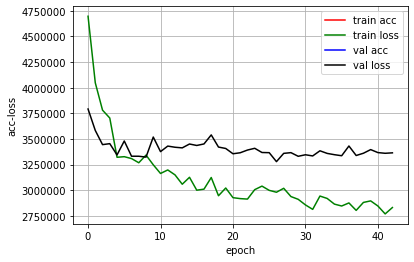

In [127]:
score = model.evaluate([val_X], [val_y1, val_y2], verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

history.loss_plot('epoch')

In [128]:
pred = model.predict([val_X])

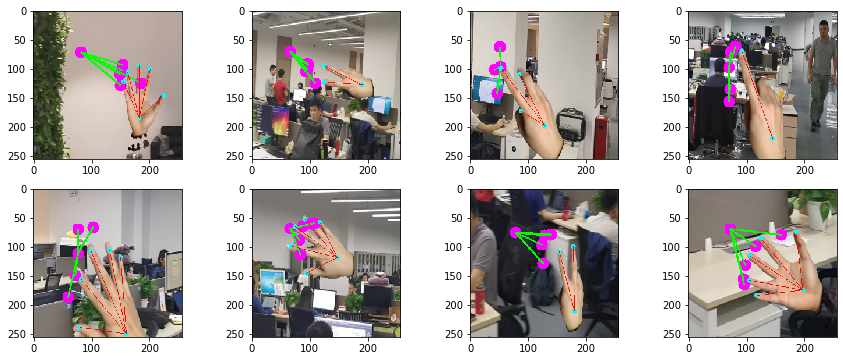

In [129]:
num_plot = [2,4]

count = 1
plt.figure(figsize=(15,6))
for i in range(num_plot[0]):
    for j in range(num_plot[1]):
        plt.subplot(num_plot[0],num_plot[1], count)
        count += 1
        idx = int(random.random() * len(val_X))
        
        image = val_X[idx].copy()
        label_test = pred[1][idx]
        flag_test = pred[0][idx]

        #image_labeled = draw_label_show(label_test, image)
        image_labeled = draw_label_show_flag(label_test, image, flag_test)
        label_test_true = val_y2[idx]
        image_labeled = draw_label_show(label_test_true, image, False)
        
        plt.imshow(image_labeled)

In [130]:
# make sample background
cap = cv2.VideoCapture(0)
if not (cap.isOpened()):
    print("Could not open video device")
else:  
    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        resized = cv2.resize(frame, (256,256), interpolation = cv2.INTER_AREA) 
        label_test = model.predict([[resized]])[1][0]
        image_labeled = draw_label_show(label_test, resized)
        
        # Display the resulting frame
        cv2.imshow('frame',image_labeled)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

In [131]:
K.clear_session()
del model
gc.collect()

24347

In [ ]:
def prediction_pipline(X,two_times=False):
    preds=[]
    for model in tqdm(models):
        pred=model.predict([X])
        preds.append(pred)
    preds=sum(preds)/len(preds)
    if two_times:
        return larger_range(preds,2)
    else:
        return preds
def larger_range(model_pred,time):
    return (((model_pred-0.5)*time)+0.5)

In [ ]:
best_model_pred=models[losses.index(min(losses))].predict([val_X])

In [ ]:
model_pred=prediction_pipline(val_X)